#Model

In [6]:
import os
import shutil
import random
import numpy as np
from zipfile import ZipFile as unzip
from google.colab import files
import matplotlib.pyplot as plt

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [8]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vinhbach1901","key":"d882345fa48ef12ff88ae64959643d0f"}'}

In [9]:
! pip install kaggle
! mkdir ~/.kaggle
! mv kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [15]:
!kaggle datasets download train-test-dogs-cats

Dataset URL: https://www.kaggle.com/datasets/vinhbach1901/train-test-dogs-cats
License(s): unknown
train-test-dogs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)


In [18]:
for _ , _  , filenames in os.walk('.'):
  for filename in filenames:
    if filename[-3:]=='zip':
      file = unzip(filename,'r')
      file.extractall()
      file.close()
      os.remove(filename)

In [20]:
print("Number of train images: " , len(os.listdir('./train/train')) )
print("Number of test images: "  , len(os.listdir('./test/test')) )

Number of train images:  25000
Number of test images:  12500


In [22]:
no_of_cats = len([files for files in os.listdir('./train/train') if 'cat' in files])
no_of_dogs = len([files for files in os.listdir('./train/train') if 'dog' in files])
print("Cat images in train dataset: ",  no_of_cats)
print("Dog images in train dataset: ", no_of_dogs)
if no_of_cats==no_of_dogs:
  total_images = no_of_cats
  print('Balanced dataset')

Cat images in train dataset:  12500
Dog images in train dataset:  12500
Balanced dataset


In [23]:
base_dir = 'data/'
dirs = ['train','val','test']
sub_dirs = ['cats','dogs']
for dir in dirs:
  dir =  os.path.join(base_dir, dir)
  os.makedirs(dir,exist_ok=True)
  for sub_dir in sub_dirs:
    sub_dir = os.path.join(dir, sub_dir)
    os.makedirs(sub_dir,exist_ok=True)

In [24]:
split = {'train': 0.7,
         'val': 0.3}

for dir in dirs[:2]:
    print(int(split[dir]*total_images))

8750
3750


In [26]:
split_size = 0.7

split = {'train': (0,int(split_size*total_images)),
         'val': (int(split_size*total_images),total_images)}

for obj in sub_dirs:
  for dir in dirs[:2]:
    files = ['{}.{}.jpg'.format(obj[:-1],i) for i in range(*split[dir])]
    for filename in files:
      src = os.path.join('./train/train', filename)
      dst = os.path.join(base_dir,dir,obj,filename)
      shutil.copyfile(src,dst)
print("Train validation split completed.")

Train validation split completed.


In [27]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

# Directory with our training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [28]:
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['cat.1656.jpg', 'cat.195.jpg', 'cat.485.jpg', 'cat.2070.jpg', 'cat.6384.jpg', 'cat.2780.jpg', 'cat.1.jpg', 'cat.371.jpg', 'cat.8250.jpg', 'cat.5520.jpg']
['dog.4851.jpg', 'dog.7871.jpg', 'dog.663.jpg', 'dog.6217.jpg', 'dog.994.jpg', 'dog.4268.jpg', 'dog.6482.jpg', 'dog.6991.jpg', 'dog.5578.jpg', 'dog.6427.jpg']


In [29]:
print('total training cat images :', len(os.listdir(      train_cats_dir ) ))
print('total training dog images :', len(os.listdir(      train_dogs_dir ) ))

print('total validation cat images :', len(os.listdir( validation_cats_dir ) ))
print('total validation dog images :', len(os.listdir( validation_dogs_dir ) ))

total training cat images : 8750
total training dog images : 8750
total validation cat images : 3750
total validation dog images : 3750


In [30]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

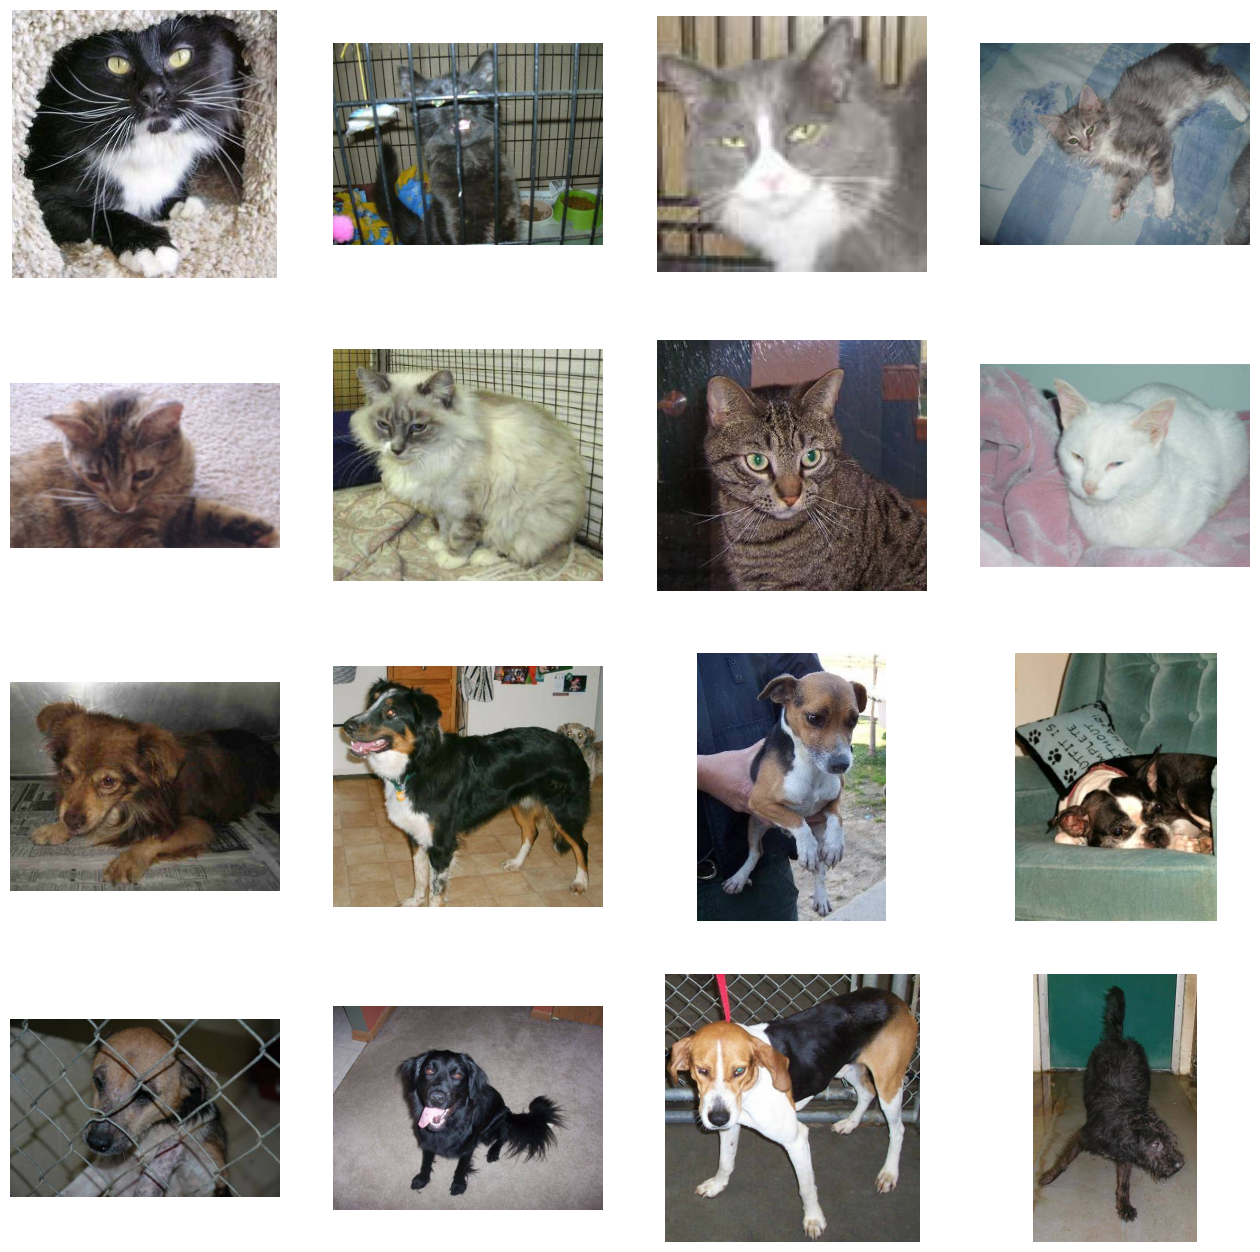

In [31]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_cat_pix = [os.path.join(train_cats_dir, fname)
                for fname in train_cat_fnames[ pic_index-8:pic_index]
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname)
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [32]:
model = tf.keras.models.Sequential([
        Conv2D(128,kernel_size=(3,3),activation='relu',input_shape=(150,150,3)),
        Conv2D(64,kernel_size=(3,3),activation='relu'),
        MaxPooling2D(4,4),

        Conv2D(128,kernel_size=(3,3),activation='relu'),
        Conv2D(64,kernel_size=(3,3),activation='relu'),
        MaxPooling2D(4,4),

        Flatten(),
        Dense(512,activation='relu') ,
        Dropout(rate=0.3),
        Dense(1, activation='sigmoid'),
        ])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [33]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 146, 146, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,323,201 (8.86 MB)

 Trainable params: 2,323,201 (8.86 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [35]:
datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = datagen.flow_from_directory(train_dir,
                                              batch_size=20,
                                              class_mode ='binary',
                                              target_size=(150,150))
validation_generator = datagen.flow_from_directory(validation_dir,
                                                   batch_size=20,
                                                   class_mode='binary',
                                                   target_size = (150,150))

Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.


(20, 150, 150, 3)
1.0


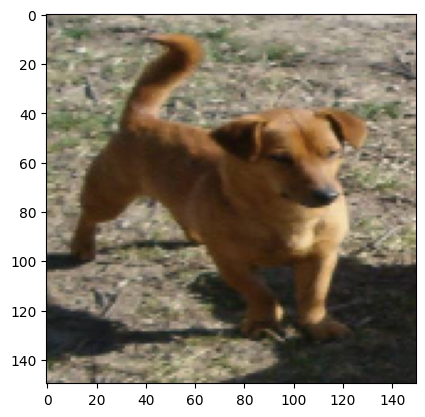

(20, 150, 150, 3)
1.0


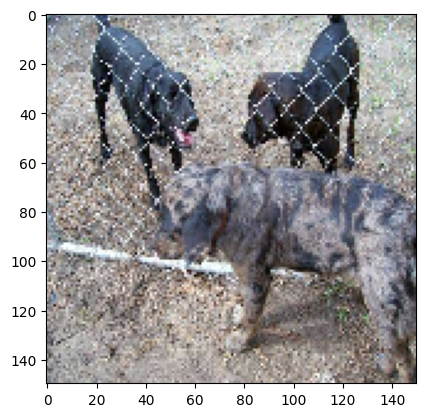

(20, 150, 150, 3)
0.0


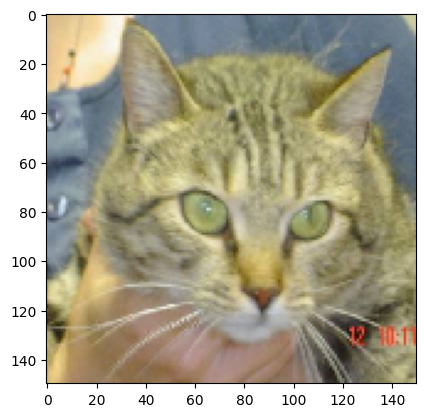

(20, 150, 150, 3)
0.0


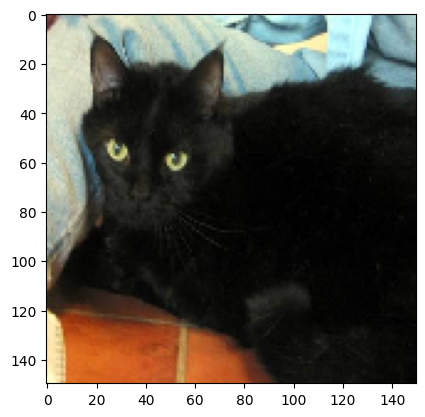

(20, 150, 150, 3)
0.0


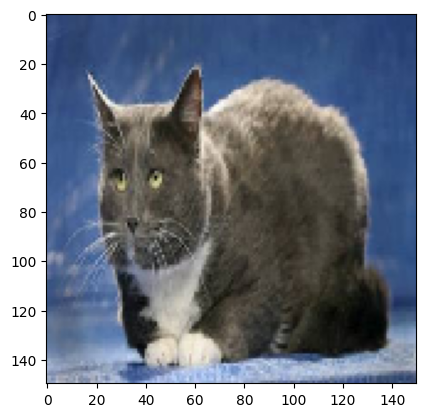

In [37]:
for _ in range(5):
    img, label = next(train_generator)
    print(img.shape)   #  (1,256,256,3)
    print(label[0])
    plt.imshow(img[0])
    plt.show()

In [ ]:
histroy = model.fit(train_generator,
                    validation_data = validation_generator,
                    steps_per_epoch=100,
                    epochs=50,
                    validation_steps = 50,
                    verbose=1)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 10/100 ━━━━━━━━━━━━━━━━━━━━ 8:51 6s/step - accuracy: 0.5799 - loss: 0.9288

In [ ]:
# save weights
model.save('cat_v_dog_model.h5')

#Predict your image

In [ ]:
from google.colab import files
uploaded=files.upload()

for fn in uploaded.keys():

  # predicting images
  path='/content/' + fn
  img=image.load_img(path, target_size=(150, 150))

  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model.predict(images, batch_size=10)

  print(classes[0])

  if classes[0]>0:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving 1.jpg to 1 (1).jpg
[0.]
1.jpg is a cat


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


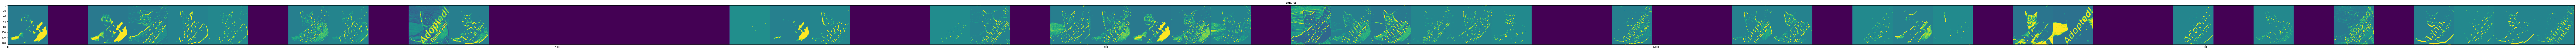

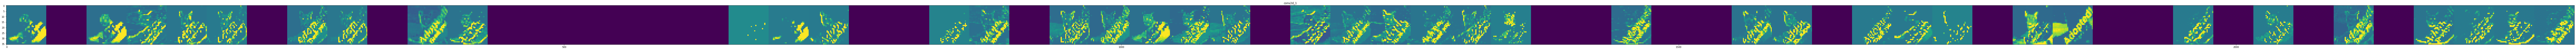

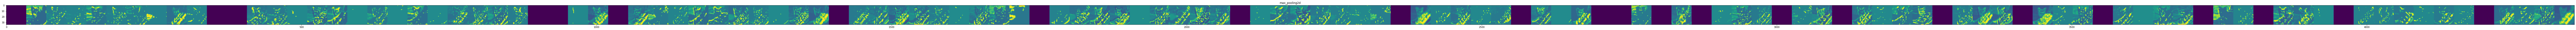

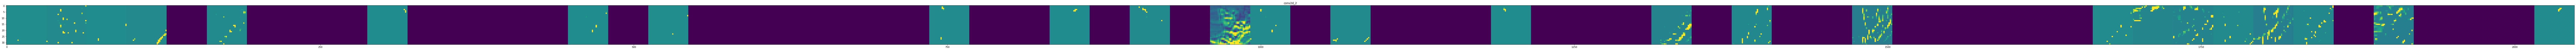

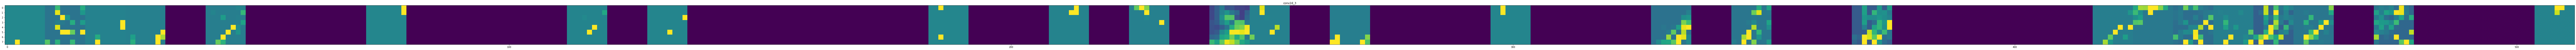

In [ ]:
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]

img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):

  if len(feature_map.shape) == 4:

    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)

    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))

    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 200. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )

In [5]:
saved_model = tf.keras.models.load_model('cat_v_dog_model.h5')

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'cat_v_dog_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [2]:
!pip install gradio tensorflow pillow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.4 MB/s eta 0:00:00


In [3]:
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image

model = tf.keras.models.load_model('cat_v_dog_model.h5')

def preprocess_image(img):
    img = img.resize((150, 150))
    img = np.array(img)
    if img.shape[2] == 4:
        img = img[..., :3]
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

def predict_image(image):
    processed = preprocess_image(image)
    pred = model.predict(processed)[0][0]
    if pred < 0.5:
        label = "Mèo"
        confidence = (1 - pred) * 100
    else:
        label = "Chó"
        confidence = pred * 100
    return f"Dự đoán: {label} với độ tin cậy {confidence:.2f}%"

iface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Dự đoán Chó hoặc Mèo",
    description="Tải lên ảnh chó hoặc mèo, mô hình sẽ dự đoán và hiển thị kết quả."
)

iface.launch()


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'cat_v_dog_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)